 ## Sentiment Analysis of daily NEWS 




#### Description:

This projects attempts to analyze the daily news we are subjected to. The complete analysis consists of 2 Sections.

<font color='red'>Section 1:</font> This section involves sentiment analysis of the news articles, We try and investigate if the sentiments associated with the news articles to answer the following questions 
1. Is the Media focussing too much on the negative side of the story? Do the negative news dominate the headlines ?
2. Is there a perticular trend in the way the major publishishers from around the world report stories?
3. Do the word distribution in news articles picked up randomly follow the zipf's law?
4. Bigram Analysis of the headlines

<font color='red'>Section 2:</font> Impact of News sentiment on stock market prices. Does it mean that if news is demoninated with negative news, the stock prices fall?


Note: While rerunning the data collection part, kindly ensure that the start date of the API call is no later than one month prior to the current date in order to avoid any errors

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import nltk 
import matplotlib
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from rake_nltk import Rake 

### Task 1: Identify a suitable web API

<font color='red'>API Chosen:</font> Two API's were chosen for this project, all the news articles were collected from https://newsapi.org/ . NewsAPI provides real time news articles from a wide variety of news publishers. The data for the stock prices was needed in the Section 2 of this project and hence another API was needed. The data was obtained from https://www.worldtradingdata.com/


In [2]:
url = 'https://newsapi.org/v2/everything?'

In [350]:
api_key = '80ec46ba9d7XXXXXXXXXXXXXXXXXXXX' 

The following two functions are used to gather the data from the api and put it in a dataframe. The get_article function
takes the raw data in the form of a dictionary and combines it in a structured format 

In [4]:
# function to take raw data from the API and process it into a list inorder to trnasform it into a pandas dataframe
def get_articles(file): 
    article_results = [] 
    for i in range(len(file)):
        article_dict = {}
        article_dict['title'] = file[i]['title']
        article_dict['author'] = file[i]['author']
        article_dict['source'] = file[i]['source']
        article_dict['description'] = file[i]['description']
        article_dict['content'] = file[i]['content']
        article_dict['pub_date'] = file[i]['publishedAt']
        article_dict['url'] = file[i]["url"]
        article_dict['photo_url'] = file[i]['urlToImage']
        article_results.append(article_dict)
    return article_results


### Task 2: Collect data your chosen API(s)
The data for this assignment was collected in two stages. Since the API had a restrictions. The API only returned 100 news articles in API call and the news could only be collected upto 1 month prior to the current date. In order to collect sufficent data for analysis, I used to approaches: 

1. Collect 100 articles per New Publishso that I could iterate through alist of News publishers and collect 100 news articles from each one of them 
2. Collect data in two phases. In phase 1 of the collection i collected data from 14th February till 14th March and in phase 2 I collected data from 15th March onwards till 29th of March 2020.

In [5]:
# Collecting the first 100 articles about ireland to check the API and the working of the function 
parameters_headlines = {
    'q': 'Ireland',
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'from' : '2020-03-15'    
}
# making the API call 
response_headline = requests.get(url, params = parameters_headlines)
response_json_headline = response_headline.json()
responses = response_json_headline["articles"]
# transforminf the data from JSON dictionary to a pandas data frame
news_articles_df = pd.DataFrame(get_articles(responses))
# printing the head to check the format and the working of the get_articles function
news_articles_df.head()

,author,content,description,photo_url,pub_date,source,title,url
0,Igor Bonifacic,"If you decide to take advantage, keep in mind ...",Today is the final day for Europeans to sign u...,https://o.aolcdn.com/images/dims?resize=1200%2...,2020-03-23T14:29:00Z,"{'id': 'engadget', 'name': 'Engadget'}",Today is the last day for Europeans to save on...,https://www.engadget.com/2020/03/23/disney-plu...
1,Ashley Carman,People can still travel within the EU\r\nPhoto...,German Chancellor Angela Merkel has announced ...,https://cdn.vox-cdn.com/thumbor/Txue8lVbJ1dluS...,2020-03-17T19:53:56Z,"{'id': 'the-verge', 'name': 'The Verge'}",European Union closes all external borders for...,https://www.theverge.com/2020/3/17/21184043/eu...
2,Monica Chin,Photo by Maddie Meyer/Getty Images Students ar...,Surprise campus closures are just the beginnin...,https://cdn.vox-cdn.com/thumbor/YWYHN6omFBDXIC...,2020-03-18T13:00:00Z,"{'id': 'the-verge', 'name': 'The Verge'}","As universities shut their doors, internationa...",https://www.theverge.com/2020/3/18/21175420/un...
3,Ingrid Lunden,"Disney+, the streaming service from the Walt D...","Disney+, the streaming service from the Walt D...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24T09:30:08Z,"{'id': 'techcrunch', 'name': 'TechCrunch'}","With lower bandwidth, Disney+ opens streaming ...",http://techcrunch.com/2020/03/24/with-lower-ba...
4,Anthony Ha,"Disney+ launches in seven European countries, ...","Disney+ launches in seven European countries, ...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24T16:33:27Z,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Daily Crunch: Disney+ launches in seven Europe...,http://techcrunch.com/2020/03/24/daily-crunch-...


As we can see from the above result that the data is correctly being transformed from a dictionary to a pandas dataframe and hence we can go ahead and loop through the list of reputated sources and make an API call to fetch 100 news articles from that source. I appended the results of each API call to the dataframe. This alowed me to collect collect sufficient data from the API

In [6]:
responses = list() # stores responses for various news sources
domains = ['wsj.com','aljazeera.com','bbc.co.uk','techcrunch.com', 'nytimes.com','bloomberg.com','businessinsider.com',
             'cbc.ca','cnbc.com','cnn.com','ew.com','espn.go.com','espncricinfo.com','foxnews.com', 'apnews.com',
             'news.nationalgeographic.com','nymag.com','reuters.com','rte.ie','thehindu.com','huffingtonpost.com',
             'irishtimes.com','timesofindia.indiatimes.com','washingtonpost.com','time.com','medicalnewstoday.com',
             'ndtv.com','theguardian.com','dailymail.co.uk','firstpost.com','thejournal.ie', 'hindustantimes.com',
             'economist.com','news.vice.com','usatoday.com','telegraph.co.uk','metro.co.uk','mirror.co.uk','news.google.com']
for domain in domains:
    parameters_headlines = {
    'domains':format(domain),
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'from' : '2020-03-15'    
    }
    rr = requests.get(url, params = parameters_headlines)
    data = rr.json()
    responses = data["articles"]
    news_articles_df=news_articles_df.append(pd.DataFrame(get_articles(responses)))

In [7]:
print(news_articles_df.shape)
news_articles_df.head()

(2887, 8)


,author,content,description,photo_url,pub_date,source,title,url
0,Igor Bonifacic,"If you decide to take advantage, keep in mind ...",Today is the final day for Europeans to sign u...,https://o.aolcdn.com/images/dims?resize=1200%2...,2020-03-23T14:29:00Z,"{'id': 'engadget', 'name': 'Engadget'}",Today is the last day for Europeans to save on...,https://www.engadget.com/2020/03/23/disney-plu...
1,Ashley Carman,People can still travel within the EU\r\nPhoto...,German Chancellor Angela Merkel has announced ...,https://cdn.vox-cdn.com/thumbor/Txue8lVbJ1dluS...,2020-03-17T19:53:56Z,"{'id': 'the-verge', 'name': 'The Verge'}",European Union closes all external borders for...,https://www.theverge.com/2020/3/17/21184043/eu...
2,Monica Chin,Photo by Maddie Meyer/Getty Images Students ar...,Surprise campus closures are just the beginnin...,https://cdn.vox-cdn.com/thumbor/YWYHN6omFBDXIC...,2020-03-18T13:00:00Z,"{'id': 'the-verge', 'name': 'The Verge'}","As universities shut their doors, internationa...",https://www.theverge.com/2020/3/18/21175420/un...
3,Ingrid Lunden,"Disney+, the streaming service from the Walt D...","Disney+, the streaming service from the Walt D...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24T09:30:08Z,"{'id': 'techcrunch', 'name': 'TechCrunch'}","With lower bandwidth, Disney+ opens streaming ...",http://techcrunch.com/2020/03/24/with-lower-ba...
4,Anthony Ha,"Disney+ launches in seven European countries, ...","Disney+ launches in seven European countries, ...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24T16:33:27Z,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Daily Crunch: Disney+ launches in seven Europe...,http://techcrunch.com/2020/03/24/daily-crunch-...


### Task 3: Cleaning and preprocessing the Data

In [8]:
# function to exatract just the name of the source of the news article and exclude other details
def source_getter(df):
    source = []
    for source_dict in df['source']:
        source.append(source_dict['name'])
    df['source'] = source #append the source to the df

In [9]:
# this fuincton extracts the source name from the source dictionary as seen above
source_getter(news_articles_df)

In [10]:
# converted the publication date to date time format for future analysis
news_articles_df['pub_date'] = pd.to_datetime(news_articles_df['pub_date']).apply(lambda x: x.date())

In [11]:
#look for missing data
news_articles_df.isnull().sum() 

author         322
content        276
description     92
photo_url      130
pub_date         0
source           0
title            0
url              0
dtype: int64

We can see that there are quite a few missing values present in the dataset and since the dataset is purely textual in nature and given the type of fields having the missing value, it is not possible to fill the missing values in this case hence I dicided to drop all rows with null values.

In [351]:
# droping the rows with missing data 
news_articles_df.dropna(inplace=True)
news_articles_df = news_articles_df[~news_articles_df['description'].isnull()]
# summarize the number of rows and columns in the dataset
print(news_articles_df.isnull().sum())
print(news_articles_df.shape)

author           0
content          0
description      0
photo_url        0
pub_date         0
source           0
title            0
url              0
combined_text    0
tokens           0
lems             0
keywords         0
dtype: int64
(4751, 12)


The title along with the content provided significant detail regarding the story and both columns contained soem keywords which were essential for futher analysis hence they were combined to form one column

In [14]:
# combine the title and the content to get one dataframe column
news_articles_df['combined_text'] = news_articles_df['title'].map(str) +" "+ news_articles_df['content'].map(str) 

In [281]:
news_articles_df.head()

,author,content,description,photo_url,pub_date,source,title,url,combined_text
0,Igor Bonifacic,"If you decide to take advantage, keep in mind ...",Today is the final day for Europeans to sign u...,https://o.aolcdn.com/images/dims?resize=1200%2...,2020-03-23,Engadget,Today is the last day for Europeans to save on...,https://www.engadget.com/2020/03/23/disney-plu...,Today is the last day for Europeans to save on...
1,Ashley Carman,People can still travel within the EU\r\nPhoto...,German Chancellor Angela Merkel has announced ...,https://cdn.vox-cdn.com/thumbor/Txue8lVbJ1dluS...,2020-03-17,The Verge,European Union closes all external borders for...,https://www.theverge.com/2020/3/17/21184043/eu...,European Union closes all external borders for...
2,Monica Chin,Photo by Maddie Meyer/Getty Images Students ar...,Surprise campus closures are just the beginnin...,https://cdn.vox-cdn.com/thumbor/YWYHN6omFBDXIC...,2020-03-18,The Verge,"As universities shut their doors, internationa...",https://www.theverge.com/2020/3/18/21175420/un...,"As universities shut their doors, internationa..."
3,Ingrid Lunden,"Disney+, the streaming service from the Walt D...","Disney+, the streaming service from the Walt D...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24,TechCrunch,"With lower bandwidth, Disney+ opens streaming ...",http://techcrunch.com/2020/03/24/with-lower-ba...,"With lower bandwidth, Disney+ opens streaming ..."
4,Anthony Ha,"Disney+ launches in seven European countries, ...","Disney+ launches in seven European countries, ...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24,TechCrunch,Daily Crunch: Disney+ launches in seven Europe...,http://techcrunch.com/2020/03/24/daily-crunch-...,Daily Crunch: Disney+ launches in seven Europe...


Applying Text Preprocessing steps:
In the followting sections, some of the text preprocessing steps were applied to the data. The steps included:
1. Tokenization 
2. Removing the non ASCII characters from the text
3. Stop words removal
4. Removing punctuations, apostrophe, special characters etc
5. lemmatize the text

In [283]:
# Function to remove non-ascii characters from the text
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)
# function to remove the punctuations, apostrophe, special characters using regular expressions
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text
# stop words are the words that convery little to no information about the actual content like the words:the, of, for etc
def remove_stopwords(word_tokens):
    filtered_sentence = [] 
    stop_words = stopwords.words('english')
    specific_words_list = ['char', 'u', 'hindustan', 'doj', 'washington'] 
    stop_words.extend(specific_words_list )
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    return filtered_sentence
# function for lemmatization 
def lemmatize(x):
    lemmatizer = WordNetLemmatizer()
    return' '.join([lemmatizer.lemmatize(word) for word in x])

In [284]:
# splitting a string, text into a list of tokens
tokenizer = RegexpTokenizer(r'\w+')
def tokenize(x): 
    return tokenizer.tokenize(x)

In [290]:
# applying all of these functions to the our dataframe 
news_articles_df['combined_text'] = news_articles_df['combined_text'].map(clean_text)
news_articles_df['tokens'] = news_articles_df['combined_text'].map(tokenize)
news_articles_df['tokens'] = news_articles_df['tokens'].map(remove_stopwords)
news_articles_df['lems'] =news_articles_df['tokens'].map(lemmatize)

In [291]:
news_articles_df.head()

,author,content,description,photo_url,pub_date,source,title,url,combined_text,tokens,lems,keywords
0,Igor Bonifacic,"If you decide to take advantage, keep in mind ...",Today is the final day for Europeans to sign u...,https://o.aolcdn.com/images/dims?resize=1200%2...,2020-03-23,Engadget,Today is the last day for Europeans to save on...,https://www.engadget.com/2020/03/23/disney-plu...,today is the last day for europeans to save on...,"[today, last, day, europeans, save, disney, de...",today last day european save disney decide tak...,"[amazon, disney, agreed, get, europeans, light..."
1,Ashley Carman,People can still travel within the EU\r\nPhoto...,German Chancellor Angela Merkel has announced ...,https://cdn.vox-cdn.com/thumbor/Txue8lVbJ1dluS...,2020-03-17,The Verge,European Union closes all external borders for...,https://www.theverge.com/2020/3/17/21184043/eu...,european union closes all external borders for...,"[european, union, closes, external, borders, d...",european union close external border day peopl...,"[maja, hitij, pool, getty, images, still, trav..."
2,Monica Chin,Photo by Maddie Meyer/Getty Images Students ar...,Surprise campus closures are just the beginnin...,https://cdn.vox-cdn.com/thumbor/YWYHN6omFBDXIC...,2020-03-18,The Verge,"As universities shut their doors, internationa...",https://www.theverge.com/2020/3/18/21175420/un...,as universities shut their doors international...,"[universities, shut, doors, international, stu...",university shut door international student lef...,"[finish, maddie, meyer, getty, images, student..."
3,Ingrid Lunden,"Disney+, the streaming service from the Walt D...","Disney+, the streaming service from the Walt D...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24,TechCrunch,"With lower bandwidth, Disney+ opens streaming ...",http://techcrunch.com/2020/03/24/with-lower-ba...,with lower bandwidth disney opens streaming se...,"[lower, bandwidth, disney, opens, streaming, s...",lower bandwidth disney open streaming service ...,"[chars, walt, disney, company, seen, lower, ba..."
4,Anthony Ha,"Disney+ launches in seven European countries, ...","Disney+ launches in seven European countries, ...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24,TechCrunch,Daily Crunch: Disney+ launches in seven Europe...,http://techcrunch.com/2020/03/24/daily-crunch-...,daily crunch disney launches in seven european...,"[daily, crunch, disney, launches, seven, europ...",daily crunch disney launch seven european coun...,"[new, ipad, pro, critical, windows, security, ..."


In [295]:
# finding the keywords using the rake algorithm from NLTK
# rake is Rapid Automatic Keyword Extraction algorithm, and is used for domain independent keyword extraction
news_articles_df['keywords'] = ""
for index,row in news_articles_df.iterrows():
    comb_text = row['combined_text']
    r = Rake()
    r.extract_keywords_from_text(comb_text)
    key_words_dict = r.get_word_degrees()
    row['keywords'] = list(key_words_dict.keys())

In [296]:
# applying the fucntion to the dataframe
news_articles_df['keywords'] = news_articles_df['keywords'].map(remove_stopwords)
news_articles_df['lems'] =news_articles_df['keywords'].map(lemmatize)

In [297]:
news_articles_df.head()
news_articles_df.to_csv('data/news_articles_clean.csv', index = False)

,author,content,description,photo_url,pub_date,source,title,url,combined_text,tokens,lems,keywords
0,Igor Bonifacic,"If you decide to take advantage, keep in mind ...",Today is the final day for Europeans to sign u...,https://o.aolcdn.com/images/dims?resize=1200%2...,2020-03-23,Engadget,Today is the last day for Europeans to save on...,https://www.engadget.com/2020/03/23/disney-plu...,today is the last day for europeans to save on...,"[today, last, day, europeans, save, disney, de...",amazon disney agreed get european light decide...,"[amazon, disney, agreed, get, europeans, light..."
1,Ashley Carman,People can still travel within the EU\r\nPhoto...,German Chancellor Angela Merkel has announced ...,https://cdn.vox-cdn.com/thumbor/Txue8lVbJ1dluS...,2020-03-17,The Verge,European Union closes all external borders for...,https://www.theverge.com/2020/3/17/21184043/eu...,european union closes all external borders for...,"[european, union, closes, external, borders, d...",maja hitij pool getty image still travel withi...,"[maja, hitij, pool, getty, images, still, trav..."
2,Monica Chin,Photo by Maddie Meyer/Getty Images Students ar...,Surprise campus closures are just the beginnin...,https://cdn.vox-cdn.com/thumbor/YWYHN6omFBDXIC...,2020-03-18,The Verge,"As universities shut their doors, internationa...",https://www.theverge.com/2020/3/18/21175420/un...,as universities shut their doors international...,"[universities, shut, doors, international, stu...",finish maddie meyer getty image student leavin...,"[finish, maddie, meyer, getty, images, student..."
3,Ingrid Lunden,"Disney+, the streaming service from the Walt D...","Disney+, the streaming service from the Walt D...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24,TechCrunch,"With lower bandwidth, Disney+ opens streaming ...",http://techcrunch.com/2020/03/24/with-lower-ba...,with lower bandwidth disney opens streaming se...,"[lower, bandwidth, disney, opens, streaming, s...",char walt disney company seen lower bandwidth ...,"[chars, walt, disney, company, seen, lower, ba..."
4,Anthony Ha,"Disney+ launches in seven European countries, ...","Disney+ launches in seven European countries, ...",https://techcrunch.com/wp-content/uploads/2020...,2020-03-24,TechCrunch,Daily Crunch: Disney+ launches in seven Europe...,http://techcrunch.com/2020/03/24/daily-crunch-...,daily crunch disney launches in seven european...,"[daily, crunch, disney, launches, seven, europ...",new ipad pro critical window security flaw dai...,"[new, ipad, pro, critical, windows, security, ..."


Note: This completed one phase of data collecton step. Exact same process was followed with just the change in date in order to get the news articles of a date beyond 1 month. Including the same proceduce twice would have made it redundant hence I have directly included the two CSV files directly.

##### Combining the data collected in two phases

In [353]:
#Combining the collected data
dataframe1=pd.read_csv("data/news_articles_clean.csv")
# dataframe1 contains the articles from 14th Feb to 14 March 
dataframe2=pd.read_csv("data/news_articles_secondgo.csv")
# dataframe2 contains the articles from 14 March to 29th March 
dataframe_combined_data = pd.concat([dataframe1, dataframe2], ignore_index=True)

In [354]:
dataframe_combined_data.to_csv('data/news_articles_combined.csv', index = False)

In [355]:
# reading the new combined data in the news_articles dataframe
news_articles_df = pd.read_csv("data/news_articles_combined.csv") 

In [393]:
# Checking the combined data once again to ensure no null value is present
print(news_articles_df.isnull().sum())
news_articles_df.dropna(inplace=True)
print(news_articles_df.shape)
print(news_articles_df.isnull().sum())

author           0
content          0
description      0
photo_url        0
pub_date         0
source           0
title            0
url              0
combined_text    0
tokens           0
lems             0
keywords         0
dtype: int64
(4751, 12)
author           0
content          0
description      0
photo_url        0
pub_date         0
source           0
title            0
url              0
combined_text    0
tokens           0
lems             0
keywords         0
dtype: int64


### Task 4: Sentiment Analysis of News articles to answer our Questions

In [357]:
# calculating the polarity of the news articles 
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for line in news_articles_df['lems'] :
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

In [358]:
# Creating a new dataframe of only the polarity score, the headline and the source of the news 
headlines_polarity = pd.DataFrame.from_records(results)
temp = []
for line in news_articles_df['source'] :
    temp.append(line)
headlines_polarity['source'] =temp

In [359]:
# categorize news as positive or negative based on the compound score obtained
headlines_polarity['label'] = 0
# I have considered the news as positive if the compound score is greater than 0.2 hence the label 1
headlines_polarity.loc[headlines_polarity['compound'] > 0.2, 'label'] = 1
# if the compound score is below 0.2 then it is considered negative 
headlines_polarity.loc[headlines_polarity['compound'] < -0.2, 'label'] = -1
# word count of news headlines is calculated
headlines_polarity['word_count'] = headlines_polarity['headline'].apply(lambda x: len(str(x).split()))

In [360]:
headlines_polarity.head()

,compound,headline,neg,neu,pos,source,label,word_count
0,-0.7650,people trying whether bottle coronavirus anxie...,0.241,0.759,0.000,Lifehacker.com,-1,27
1,-0.5279,deal oftenor asking whether stock preparing co...,0.184,0.816,0.000,Lifehacker.com,-1,27
2,0.2589,there also let doesnt kill virus coronavirus v...,0.152,0.669,0.179,Lifehacker.com,1,30
3,0.0516,coronavirus map contain serious malware know c...,0.116,0.762,0.123,Lifehacker.com,0,27
4,-0.6369,federal fund rate target char fed coronavirus ...,0.233,0.709,0.057,Lifehacker.com,-1,25


In [361]:
#headlines_polarity.label.value_counts()
#headlines_polarity.groupby('source').label.value_counts()
# Grouping the news articles by their source and calculating their mean polarity  
gk = headlines_polarity.groupby(['source', 'label']) 
fk= headlines_polarity.groupby('source')['compound'].mean()
fk = fk.to_frame()
fk.to_csv('data/mean_polarity.csv', index = 'source')

### Visualizations

In [362]:
# libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
#import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import scattertext as st


[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

Text(0, 0.5, 'Percentage')

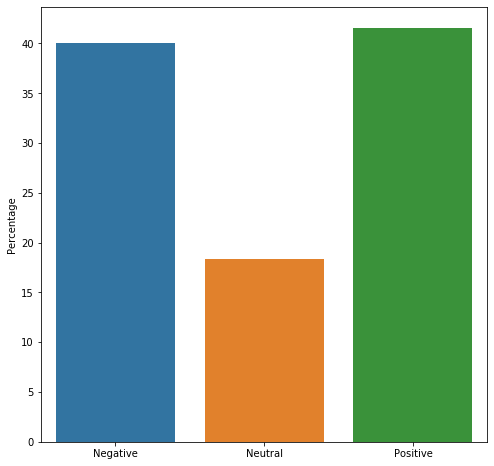

In [363]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))
counts = headlines_polarity.label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()

<font color='red'>Insights:</font> It is clear from the above bar chart that the distribution of news is quite even when it comes to the polarity of the news. Both Positive and negative sentiment accounted for about 40% each despite the time frame in which the newss articles were collected. At the prima facie level, this goes on to show that the media outlets are not biased towards the negative news.

In [364]:
headlines_polarity['compound'].iplot(
    kind='hist',
    bins=30,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

<font color='red'>Insights:</font> The graph above shows the univariate polarity distribution of the news article headlines and it can be seen that the polarity score of the headlines is quite equally distributed across the range of 1 to -1. We have equal number of records on both sides of 0. Thus now we can reach a conclusion that though we often feel that only the negative news make it to the headlines, that is certainly not the case. It is our brain that is susceptible to this negativity bias, wherein we forget the positive side of the story and focus only on the negative side of it.  

Text(0.5, 0, ' Mean Polarity')

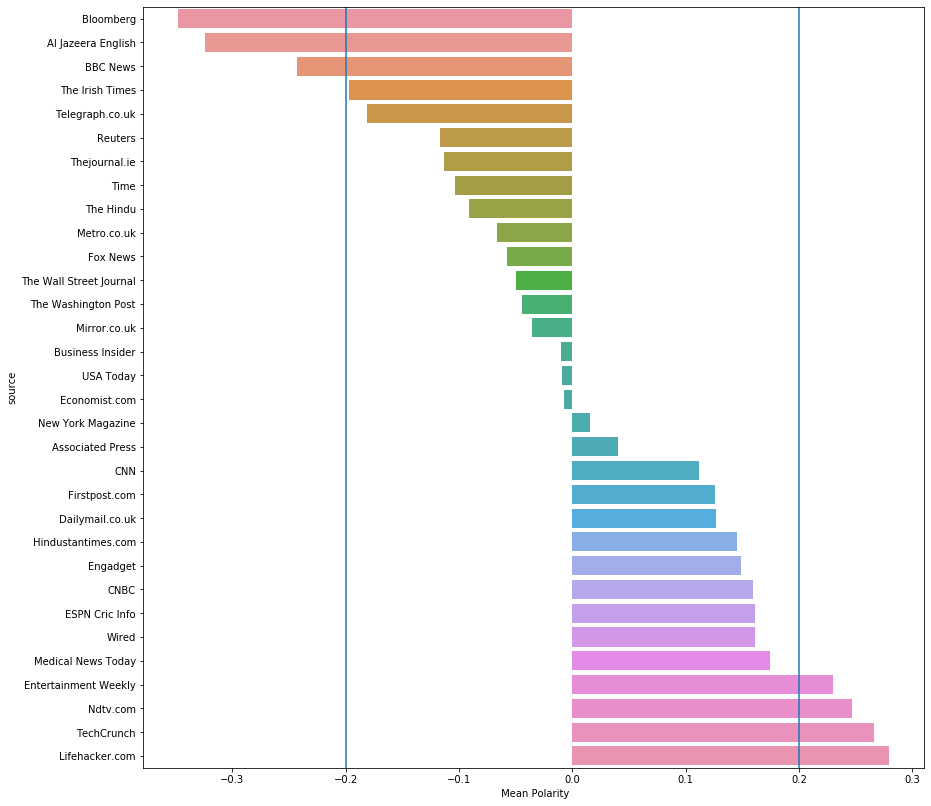

In [365]:
# Checking out the distribution of the news polarity based on the source of news
df_polarity = pd.read_csv('data/mean_polarity.csv')
df_polarity = df_polarity.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='source', data=df_polarity)
ax.set_xlabel(' Mean Polarity')
ax.axvline(0.2)
ax.axvline(-0.2)

<font color='red'>Insights:</font> The bar chart above shows mean polarity of some of the top news publishers from around the world.The two verical lines act a baseline to categorize whether the overall sentiment of the news is positive or negative. We can see that Bloomberg, Al Jazeera and BBC news have a negative mean polarity. which means these publishers genearally tend to cover stories that are negtive in its sentiments. Al jazeera mainly focuses on the war torn middle earth therfore, it is not surprising for it to have neagtive mean polarity. Bloomberg mainly covers the finance realted news or the news related to the stock market and one possible reason for it to have negative news polaity is Coronavirus Pandemic,  which has had a profound impact on the financial market in the last one month. However, It is surprising to find BBC on top of that list
We can also see that the news publishers like Techcrunch and lifehacker which often focus on tech news have a positive mean polarity 

In [366]:
# Box Plot for the top news publishers
y0 = headlines_polarity.loc[headlines_polarity['source'] == 'Al Jazeera English']['compound']
y1 = headlines_polarity.loc[headlines_polarity['source'] == 'BBC News']['compound']
y2 = headlines_polarity.loc[headlines_polarity['source'] == 'The Wall Street Journal']['compound']
y3 = headlines_polarity.loc[headlines_polarity['source'] == 'The Washington Post']['compound']
y4 = headlines_polarity.loc[headlines_polarity['source'] == 'Economist.com']['compound']
y5 = headlines_polarity.loc[headlines_polarity['source'] == 'Hindustantimes.com']['compound']

trace0 = go.Box(
    y=y0,
    name = 'Al Jazeera',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'BBC',
    marker = dict(
        color = 'rgb(0, 150, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Wall Street Journal',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'Washington Post',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Economist',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'Hindustantimes',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "Sentiment Polarity Boxplot of Popular News publishers"
)
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Sentiment Polarity Boxplot of Popular News publishers")

<font color='red'>Insights:</font> The box plot above shows five number summary for the top news publishers. The five number summary, which includes the minimumm, Q1 (the first quartile, or the 25% mark), the median, Q3 (the third quartile, or the 75% mark), and the maximum gives us the detailed idea about the exact nature of news these sources publish.sometimes mean can be misleading as it is prone to extreame values or outliers and in such cases median gives us a better idea. 
Looking at the graph we can see that the all the publishers report news on both sides of the spectrum. i.e. positive and negative. The median for Al jazeera and BBC is significantly low which confirms without any doubt that these publishers tend to have negative outlook to their stories.
The highly reputed, Washington Post stands by its high standards and has the median news polarity of exact 0. So does The Economist. Both of these news publishers also have highest interquartile range which goes on to show they cover both sides of the stories and are not biased.

In [367]:
y0 = headlines_polarity.loc[headlines_polarity['source'] == 'Al Jazeera English']['word_count']
y1 = headlines_polarity.loc[headlines_polarity['source'] == 'BBC News']['word_count']
y2 = headlines_polarity.loc[headlines_polarity['source'] == 'The Wall Street Journal']['word_count']
y3 = headlines_polarity.loc[headlines_polarity['source'] == 'The Washington Post']['word_count']
y4 = headlines_polarity.loc[headlines_polarity['source'] == 'Economist.com']['word_count']
y5 = headlines_polarity.loc[headlines_polarity['source'] == 'Hindustantimes.com']['word_count']

trace0 = go.Box(
    y=y0,
    name = 'Al Jazeera',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'BBC',
    marker = dict(
        color = 'rgb(0, 150, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Wall Street Journal',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'Washington Post',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Economist',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'Hindustantimes',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "Headline Length Boxplot of Popular News publishers"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Headline Length Boxplot of Popular News publishers")

 <font color='red'>Insights:</font> The word count in the headline is often neglected but it is a critical aspect when  it comes to engaging with the viewers. According to a research it was discovered that the sweet spot for headlines is 18–30 words. Anything above and below that saw reduced click-through rates. We see that most of the news sources seem follow the similar trend. The Economist is quite consistent with its headline length and has no outliers or extreame values. BBC on has the least variance in the headline length. 

In [368]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
print(type(stop_words))
specific_words_list = ['char', 'u', 'hindustan', 'doj', 'washington'] 
#stop_words.extend(specific_words_list )
def process_text(headlines):
    tokens = []
    for line in headlines:
        line = line.lower()
        toks = tokenizer.tokenize(line)
        toks = [t for t in toks if t not in stop_words]
        tokens.extend(toks)  
    return tokens

<class 'list'>


##### word Frequency Distribution and Zipf's law 

Zipf law: Zipf's law states that given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table. So word number n has a frequency proportional to 1/n.
Thus the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, etc.
For example, in one sample of words in the English language, the most frequently occurring word, 'the', accounts for nearly 7% of all the words (69,971 out of slightly over 1 million). True to Zipf's Law, the second-place word 'of' accounts for slightly over 3.5% of words (36,411 occurrences). (source: wikipedia)

So essentially what the law actually states is that:
1. The most appearing word in a corpus suppose has frequency f
2. The second most appearing word would have frequency roughly f/2
3. Then the third most appearing word would have frequency roughly f/3
4. Then the fourth most appearing word would have frequency roughly f/4
and so on.

What is astonishing is that this law holds true for almost all large natural language corpuses.For eg : Books, ancient scripts, even temperature trends over past years etc.

I decided upon coming across Zipf’s Law that I will investigate if the mysterious Zipf's law holds true for a news corpus collected from not one but as many as 39 differnt sources of news article.

In [369]:
# Positive headlines and its distribution 
pos_lines = list(headlines_polarity[headlines_polarity.label == 1].headline)
# extract the headlines that had label =1 which meant it had a positive overall sentiment
pos_tokens =process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

# Now negative headlines
neg_lines = list(headlines_polarity[headlines_polarity.label == -1].headline)
# extract the headlines that had label-1 which meant it had a negative overall sentiment
neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

Plotting the word distribution for positive sentiment words seperately and negative sentiment words seperately so that we can verify the law twice on the same corpus.

Text(0.5, 0, 'Words')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Word Frequency Distribution (Positive)')

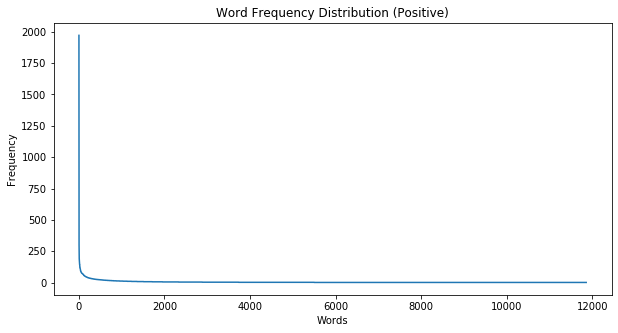

In [370]:
# plotting the word distribution for positive headlines
y_val = [x[1] for x in pos_freq.most_common()]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

Text(0.5, 0, 'Words')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Word Frequency Distribution (Negative)')

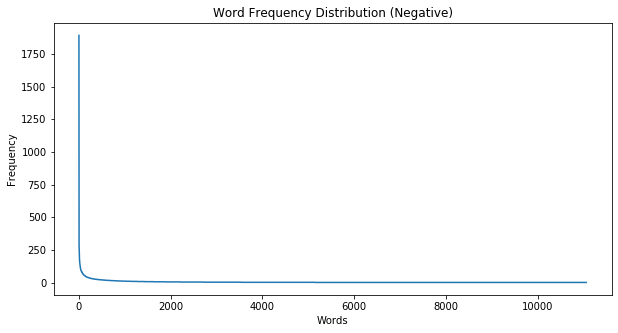

In [371]:
# Plotting the word frequency distribution for negative headlines
y_val = [x[1] for x in neg_freq.most_common()]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

<font color='red'>Insights:</font> It can be seen from the above two plots that the both the Positive sentiment words as well as the negative sentiment words follow the zipf's law. Now the how do we know whether it follws the zipfs's law? 
By observing the plot we see words close to zer have a very high word frequency and then it drops to an 'L' shaped curve. which is typical characteristic of a zipfian distribution. Furthermore, It can also be inferred that Zipf’s law follows the Pareto distribution where only first 20 % of words results into 80 % of frequency of entire corpus.
It is important to mention that In all the results, there are some instances where the word frequency not always falls to 1/2 to its previous, which is fine because overall pattern approximates the nature.

#### Wordcloud : To see whats dominating the news articles 

<Figure size 1080x1080 with 0 Axes>

(-0.5, 1499.5, 1199.5, -0.5)

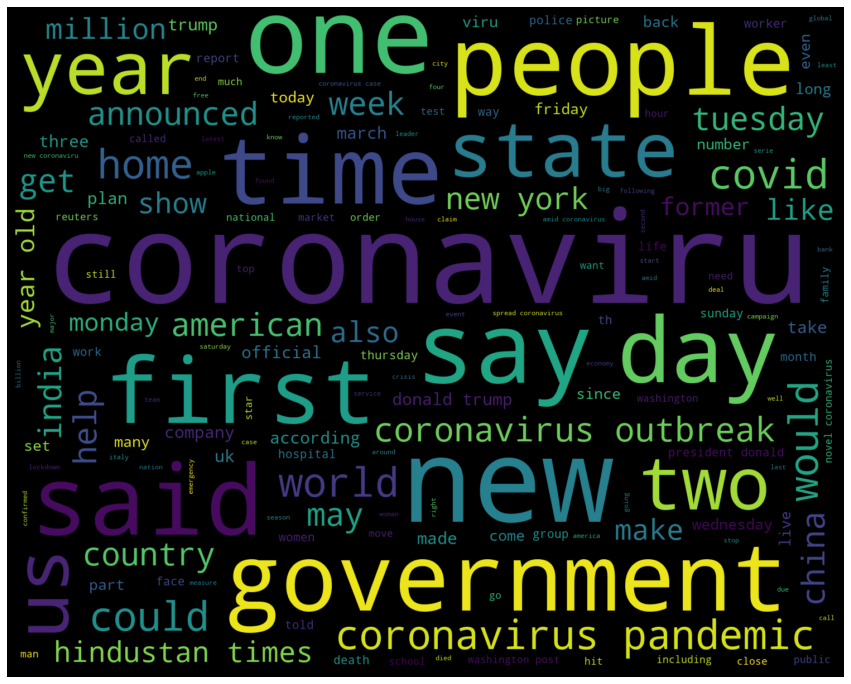

In [372]:
data=news_articles_df
stop = ["https", "co", "char","chars"] + list(stop_words)
wc = WordCloud(stopwords=stop, max_words=700, margin=10, background_color='black',
scale=3, relative_scaling = 0.4, width=500, height=400,
random_state=1).generate(' '.join(data['combined_text']))
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<font color='red'>Insights:</font> The word cloud is a analysis technique wherein more commonly the term appears within the text being analysed, the larger the word appears in the image generated. The Word cloud image above shows which words dominated the content of the news during the period of feb 14 to march 29. It is no surprise here that the term Coronavirus appears the largest in the word cloud, highlighting the global scale of the this pandemic. some of the other words that appear frequently in the news is government which I believe is again related to Covid-19 and government's response to it. some of the other interesting observation here is the term first and new. it is not quite clear in what context these were used and we will perform bigram analysis to better understand the context of these words. 
US and India also appear to have appeaared significantly in the news, this is because of President Trump's India visit in february this year. Moreover most of the News agencies are based in the US and as a result of which the they cover a lot of stories involving the United States.

####  Analyzing the distribution of words and Biagram Analysis

In [373]:
# news article specific stopwords were downloaded from:  https://github.com/vikasing/news-stopwords.git
# Then, I removed all the news specific stopwords  from my dataframe's column of token 
def remove_stopwords(params):
    with open('data/sw.csv','r') as my_stopwords:
        stopwords_list = my_stopwords.read()
        new_list = []
        for param in params:
            if str(param) not in stopwords_list:
                new_list.append(param)
            else:
                pass # You can write something to do if the stopword is found
    my_stopwords.close()
    return (new_list)
new_list = remove_stopwords(news_articles_df['tokens'])

In [374]:
# A genralized function to fetch the top n words from the corpus 
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(news_articles_df['combined_text'], 20)

df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

df1.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in the News article before removing stop words')

<font color='red'>Insights:</font> We can see that before removing the stop word, the top 20 most frequently occuring words in the corpus are the, to, of, in, etc which does not make much sense these are the words that do not convey any anything about the topic. Other thing to notice here is that again even here we do see the distribution following the zipf's law. 

In [375]:
common_words = get_top_n_words(new_list, 20)
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in News articles after removing stop words')


<font color='red'>Insights:</font> After removing the stopwords we see that after removing the news specific stopwords, now most of the words make a lot momre sense, even though there are still some stop words present like chars, one, two which do not make much sense but overall we that the stop word removal does a good job to give us an indication as to what dominated the news. Coronavirus as expected, occured 2778 times in the arounf 4000 news articles. other frequent words compliment the wordclound plot described earlier. 

##### Bigram  Analysis
Some English words occur together more frequently. For example - blue sky, do or die, best performance, heavy rain etc. So, in a text document. lets analyze which two words appeared most frequently in the news article corpus.

In [376]:
# A genralized function to extact the top n most frequently occuring bigram from the text corpus 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(new_list, 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
df4.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in News Corpus after removing stop words')

coronavirus pandemic 275
coronavirus outbreak 248
new york 200
year old 182
donald trump 175
president donald 142
novel coronavirus 120
spread coronavirus 113
amid coronavirus 102
new coronavirus 99
coronavirus cases 96
positive coronavirus 92
white house 89
tested positive 88
th chars 82
united states 82
social distancing 81
wall street 80
bernie sanders 76
joe biden 75


<font color='red'>Insights:</font> We can see that by looking at bigrams instead of just single words we are able to get a better sense of the what is trending in the news. We can see that the word new york bigram makes sense now as compared to earlier. Those two words individually do not make any sense but now looking at bigram we can notice that it is acttually referring to the New York City and it is probably in the news after it has now emerged as the new Coronavirus hotspot with close to 1000 deaths. We can also see the word social distancing which signifies the emphasis being given by the media on it.

In [377]:
# extracting the parts of specch from the news headlines using textBlob
blob = TextBlob(str(news_articles_df['title']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:5]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for News Headlines')

1. NNP: Proper noun
2. CD : Cardinal digit
3. NN : Noun
4. IN : Preposition/subordinating conjunction
5. VB : Verb

<font color='red'>Insights:</font> We can see that the parts of speech used in the News article's heaadlines are dominated by the aforementioned parts of speech. We see proper nouns appearing a lot because news articles often talk about people and or place therfore it's not surprising to see proper noun at the first place. Cardinal digit was the second most appearing POS. The reason is that the Headlines are specific and give us the quantity for example: "900 People die In Italy in one single day". Including numbers in the headlines make them specific and increase its impact on the reader. Furthermore, Headlines are complete sentences and hence the presence of preposition and conjuctions. Lastly, the Headlines are full of action verbs since they have maximum imapct on the user. 

#### SECTION 2- Analyzing the share market

As News articles provides large volumes of real-time news and update, investors can potentially exploit that information by leveraging machine learning and natural language processing techniques. So do the sentiment associated with the financial news explain the volatile nature of stock market? Does the negative sentiments of the news articles for that perticular day have an impact on the closing rates of the stocks for that day? 
The following section attempts to analyze if there exists a correlation between the news sentiment and the closing price.

The stock market Data for this Analysis was fetched from Word trading data and the details can be found here:
https://www.worldtradingdata.com/documentation#historical-market-data

In [378]:
# Inorder to save time and effort I have used a python SDK which is available here: https://pypi.org/project/worldtradingdata/
import pywtd as wtd
wtd.ApiConfig.api_key = 'omZGS8bt2FxC5DQklJePpk766mJQBfctaLFpmKTIQMS63JU0WzioFGU1Ne81'

Getting the stock market data from 1st March to 30 March 2020

In [379]:
# Gs is stock market listing for goldmann Sachs
stock_data = wtd.get('GS', date_from='2020-03-01', date_to='2020-03-30')
stock_data.index.names = ['date']
stock_data=stock_data.reset_index()
stock_data.to_csv('data/Goldman_sachs.csv', index = False)

Collecting News Articles related to the JP morgan and share market in general

In [380]:
# collecting all the news Articles from the same period as the stock market prices
responses = list() 
parameters_headlines = {
    'domains': 'marketwatch.com',
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'from' : '2020-03-01'    
    }
rr = requests.get(url, params = parameters_headlines)
data = rr.json()
responses = data["articles"]
stock_articles=pd.DataFrame(get_articles(responses))
stock_articles.head()

,author,content,description,photo_url,pub_date,source,title,url
0,Therese Poletti,Slack Technologies Inc. is seeing more interes...,"Workers staying home are using Slack, but that...",https://s.marketwatch.com/public/resources/ima...,2020-03-13T00:57:41Z,"{'id': None, 'name': 'Marketwatch.com'}","Workers staying home are using Slack, but that...",http://www.marketwatch.com/story/workers-stayi...
1,Mark DeCambre,S&amp;P 500 exchange-traded funds on Thursday ...,Trading in S&P 500 ETF implies the stock marke...,https://s.wsj.net/public/resources/MWimages/MW...,2020-03-12T13:37:58Z,"{'id': None, 'name': 'Marketwatch.com'}",Trading in S&P 500 ETF implies the stock marke...,http://www.marketwatch.com/story/trading-in-sp...
2,Associated Press,Australias share benchmark initially plunged 8...,Sydney’s ASX/S&P 200 drops about 8%; only Nikk...,https://s.marketwatch.com/public/resources/ima...,2020-03-23T03:06:45Z,"{'id': None, 'name': 'Marketwatch.com'}","Asian markets fall, led by plunge from Austral...",http://www.marketwatch.com/story/asian-markets...
3,Jacob Passy,With the number of confirmed cases of COVID-19...,"As coronavirus spreads, CDC warns Americans ab...",https://s.marketwatch.com/public/resources/ima...,2020-03-13T10:46:46Z,"{'id': None, 'name': 'Marketwatch.com'}","As coronavirus spreads, CDC warns Americans ab...",http://www.marketwatch.com/story/as-coronaviru...
4,Ciara Linnane,The coronavirus that causes COVID-19 has led m...,CVS plans to hire furloughed workers from its ...,https://s.marketwatch.com/public/resources/ima...,2020-03-24T12:00:43Z,"{'id': None, 'name': 'Marketwatch.com'}",CVS plans to hire furloughed workers from its ...,http://www.marketwatch.com/story/cvs-plans-to-...


Converting the date column from both the dataframes into date time format

In [381]:
# stock news articles
stock_articles['date'] = pd.to_datetime(stock_articles['pub_date']).apply(lambda x: x.date())
# stock market data 
stock_data['date'] = pd.to_datetime(stock_data['date']).apply(lambda x: x.date())

I wanted both the dataframes merged into one so that it is easy for plotting therfore I merged the two data frame on date column 

In [382]:
df_merged=stock_data.merge(stock_articles,on='date')
df_merged.head()

,date,open,close,high,low,volume,author,content,description,photo_url,pub_date,source,title,url
0,2020-03-02,201.41,209.47,209.62,197.63,5285526,Mark DeCambre,Gold futures were rebounding Monday morning af...,Gold futures rebound Monday morning after the ...,http://s.marketwatch.com/public/resources/MWim...,2020-03-02T14:26:27Z,"{'id': None, 'name': 'Marketwatch.com'}",Metals Stocks: Gold bounces sharply higher aft...,https://www.marketwatch.com/story/gold-bounces...
1,2020-03-02,201.41,209.47,209.62,197.63,5285526,Elisabeth Buchwald,Barrons wants to recognize people and organiza...,Monday’s top personal finance stories,https://mw3.wsj.net/mw5/content/logos/mw_logo_...,2020-03-02T22:18:22Z,"{'id': None, 'name': 'Marketwatch.com'}",Personal Finance Daily: How America’s extreme ...,https://www.marketwatch.com/story/how-americas...
2,2020-03-02,201.41,209.47,209.62,197.63,5285526,Mark Weisbrot,The biggest demographic divide in the current ...,Older Americans should pay attention to the vi...,http://s.marketwatch.com/public/resources/MWim...,2020-03-02T15:49:07Z,"{'id': None, 'name': 'Marketwatch.com'}","Outside the Box: On Social Security benefits, ...",https://www.marketwatch.com/story/on-social-se...
3,2020-03-02,201.41,209.47,209.62,197.63,5285526,Jaimy Lee,The U.S. now has reported multiple instances o...,The U.S. now has reported multiple instances o...,http://s.marketwatch.com/public/resources/MWim...,2020-03-02T15:26:16Z,"{'id': None, 'name': 'Marketwatch.com'}","Coronavirus update: 89,197 cases, 3,048 deaths...",https://www.marketwatch.com/story/coronavirus-...
4,2020-03-02,201.41,209.47,209.62,197.63,5285526,Pierre Briançon,The Organisation for Economic Co-operation and...,"World economy “at risk” if nothing is done, or...",http://s.marketwatch.com/public/resources/MWim...,2020-03-02T11:58:10Z,"{'id': None, 'name': 'Marketwatch.com'}",OECD calls for global fiscal stimulus to count...,https://www.marketwatch.com/story/oecd-calls-f...


In [383]:
# applying all the preprocessing steps that were described in section 1
# merging the title and content and the description 
df_merged['combined_text'] = df_merged['title'].map(str) +" "+ df_merged['content']+" "+ df_merged['description'].map(str)

In [384]:
# keeping only the essential columns in the dataframe
df_merged=df_merged[['date','close','combined_text']]
df_merged.head()

,date,close,combined_text
0,2020-03-02,209.47,Metals Stocks: Gold bounces sharply higher aft...
1,2020-03-02,209.47,Personal Finance Daily: How America’s extreme ...
2,2020-03-02,209.47,"Outside the Box: On Social Security benefits, ..."
3,2020-03-02,209.47,"Coronavirus update: 89,197 cases, 3,048 deaths..."
4,2020-03-02,209.47,OECD calls for global fiscal stimulus to count...


In [385]:
# Calculating the sentiment scores for the Sttock news articles exactly as described earlier

In [386]:
sia = SIA()
results = []
for line in df_merged['combined_text'] :
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)
# to avoid an error
pd.set_option('mode.chained_assignment', None)
df_merged['compound']=''
df_merged['neg']=''
df_merged['neu']=''
df_merged['pos']=''
for index,sentence in enumerate(df_merged['combined_text']):
    ps=sia.polarity_scores(sentence)
    df_merged['compound'][index]=ps['compound']
    df_merged['neg'][index]=ps['neg']
    df_merged['neu'][index]=ps['neu']
    df_merged['pos'][index]=ps['pos']

In [387]:
df_merged.head()

,date,close,combined_text,compound,neg,neu,pos
0,2020-03-02,209.47,Metals Stocks: Gold bounces sharply higher aft...,0.1779,0.115,0.773,0.112
1,2020-03-02,209.47,Personal Finance Daily: How America’s extreme ...,0.8481,0,0.863,0.137
2,2020-03-02,209.47,"Outside the Box: On Social Security benefits, ...",0.9376,0.036,0.753,0.211
3,2020-03-02,209.47,"Coronavirus update: 89,197 cases, 3,048 deaths...",0.34,0.062,0.849,0.089
4,2020-03-02,209.47,OECD calls for global fiscal stimulus to count...,0.6486,0,0.924,0.076


From the above dataframe we can see that there are two or more entries for the same date. which is because there can be more than one news article being published on a day so I decided to keep the most recent news and the sentiment associated with it.

In [388]:
df_merged=df_merged.drop_duplicates(subset='date', keep="last")
df_merged.head()

,date,close,combined_text,compound,neg,neu,pos
4,2020-03-02,209.47,OECD calls for global fiscal stimulus to count...,0.6486,0,0.924,0.076
9,2020-03-03,203.43,Market Snapshot: U.S. stock futures wobble low...,-0.6124,0.089,0.87,0.041
14,2020-03-04,208.74,NewsWatch: Dow industrials seen opening sharpl...,0.9118,0.021,0.8,0.179
22,2020-03-05,198.79,Commodities Corner: Oil shipments to China reb...,-0.9382,0.161,0.813,0.026
30,2020-03-06,192.85,The MarketWatch Q&A: Don’t expect interest rat...,0.5994,0.022,0.916,0.062


Now for the purpose of plotting both the stock market close price and the negative sentiment on the same plot and the axis, the close price of the stock market must be between 0 and 1 just like the sentiment score. Therefore I decided to normalize it using sklearn library.  

In [389]:
# Min-Max Normalization 
from sklearn import preprocessing
# Create x, where x the 'scores' column's values as floats
x = df_merged[['close']].values.astype(float)
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()
# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)
# adding the new column to our dataframe
df_merged['normal_close']= x_scaled

In [390]:
df_merged.head()

,date,close,combined_text,compound,neg,neu,pos,normal_close
4,2020-03-02,209.47,OECD calls for global fiscal stimulus to count...,0.6486,0,0.924,0.076,1.000000
9,2020-03-03,203.43,Market Snapshot: U.S. stock futures wobble low...,-0.6124,0.089,0.87,0.041,0.918926
14,2020-03-04,208.74,NewsWatch: Dow industrials seen opening sharpl...,0.9118,0.021,0.8,0.179,0.990201
22,2020-03-05,198.79,Commodities Corner: Oil shipments to China reb...,-0.9382,0.161,0.813,0.026,0.856644
30,2020-03-06,192.85,The MarketWatch Q&A: Don’t expect interest rat...,0.5994,0.022,0.916,0.062,0.776913


Text(0, 0.5, 'Normalized stock close')

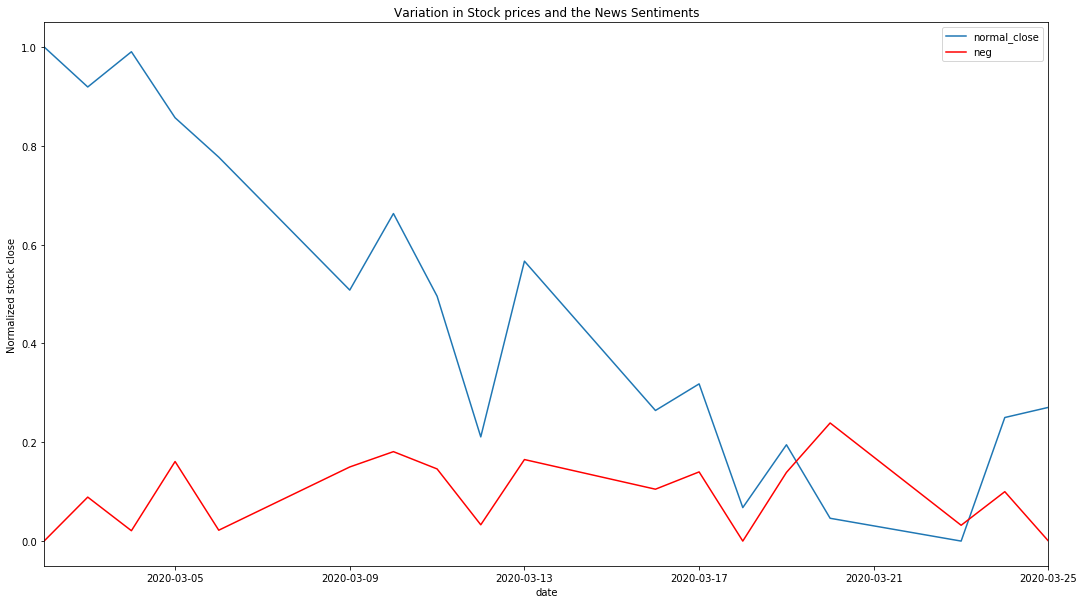

In [391]:
import matplotlib.pyplot as plt
import pandas as pd
# gca stands for 'get current axis'
ax = plt.gca()
df_merged.plot(kind='line',x='date',y='normal_close',ax=ax, figsize=(18,10))
ax.set_ylabel("Normalized stock close")
df_merged.plot(kind='line',x='date',y='neg', color='red',title='Variation in Stock prices and the News Sentiments', ax=ax, figsize=(18,10))
#plt.show()

Calculating Correlation Coedicents to emperically determine the relationship between the variables

In [392]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
# calculate the Pearsons and Spearmans correlation between two variables
# prepare data
data1 = df_merged['neg']  
data2 = df_merged['normal_close'] 
# calculate Pearson's correlation
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
# calculate Spearmans's correlation (non gaussian distribution)
corr, _ = spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: -0.100
Spearmans correlation: -0.053


<font color='red'>Insights:</font> Form the Data collected, and the graph drawn above there seem to be no correslation between the negative sentiment of the news and the stock's end of the daya close price. I further confirmed this by calculating the correlation coefficents, namely pearson's and Spearmann's. Both of them vary between -1 and 1 wherein -1 shows negative correlation and 1 shows positive correlation between the two entities. I calculated both of them because pearsonn's correlation is not suitable when the distribution of daa is normal in nature. So in all such cases, spearmans corelation is used but foe this analysis none of them suggested the presence of strong correlation between the two variables. I even tried changing various news sources and the company listing but none of them showed any signs of correlation. The correlation coefficents do suggest small negative correlation but that is small and insignificant.

I expected the end of the day stock price to have negative correlation with negative news sentiment but then results proved otherwise. Upon some critical thinking and research I was able to figure out the reason for the same. Due to the prevailing economic conditions, the behaviour of the financial markets is negative in nature and the coronavirus pandemic has negatively afftected all the major industries. As a result of which this, the present scenario is probably the worst time to do such analysis as there are multiple factors affeting the stock prices, and moreover when the world economy is heading into the biggest recession of our lifetime, the analysis results do not capture the entire story. 

### Conclusion 

In summary, we have answered for the initial questions through the means of analysis of the news articles. We have concluded that though we may feel as if the media is focussing too much on the negative side of the story, this is certainly not the case in reality. The Positive and the negative sentiments associated with over 4000 news articles clearly  indicates that both sentiments are equally present in the news articles. Furthermore, We also found that there are some news publishers like Al Jazeera and BBC news that have a high median negative sentiment polarity. 
We were also able to figure out the Ideal length of the headleans from the trends observed. It seemed 18-30 words made up the headline in most news articles.
All the subsequent analysis focussed on finding the major trends in the news and to analyse how the content of news articles and headlines. In the final section, We performed the sentiment analysis of the financial market news to determine if there exists any correlation between the end of the day close price and the negative news sentiment, It was found that there appears to be very small degree of negative correlation between the two.

In Conclusion, I beleive this project was an attempt to perform Sentiment analysis of the News articles and see its impact on the world around us. In future, I would love to collect more  historial data for the stock prices and the news sentiments (for atleast 5-10 year period ) and then analyze the presence of any correlation between the same. Sice the primary aim of this project was not to determine the correlation between the two, I have kept things simple in the second section of this project. In future, We can also fit a machine learning model to predict the close price of stock from the news sentiment. 